# Github Bug Prediction with Sagemaker

The main objective of this project is to apply Deep Learning NLP based techniques to predict the bugs, features, and questions based on GitHub titles and the text body.

We need to predict

    ● Bug - 0
    ● Feature - 1
    ● Question - 2
given Github titles and text.

First install sagemaker, kaggle and transformers

In [1]:
!pip install sagemaker==1.72.0
!pip install kaggle
!pip install transformers

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


Import libraries which will be required in our project.

In [2]:
import os
import json
import zipfile
import torch
import pandas as pd
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.optim import lr_scheduler
from sklearn import model_selection
from sklearn import metrics
import transformers
import tokenizers
from tqdm.autonotebook import tqdm
from tokenizers import BertWordPieceTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader


import warnings
warnings.filterwarnings('ignore')

# Import sagemaker related libraries
import boto3
import sagemaker
from sagemaker import get_execution_role

First create directory named kaggle which will have json file.

In [3]:
%mkdir .kaggle
!touch .kaggle/kaggle.json

Create kaggle.json file which will have api key to download the dataset

In [4]:
api_token = {"username":"codewarrior0","key":"c01b65090e3a59a881fd19675d7a54e1"}

with open('/home/ec2-user/SageMaker/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /home/ec2-user/SageMaker/.kaggle/kaggle.json
%mv .kaggle /home/ec2-user

# Download data from Kaggle

First create data directory named kaggle which will have all the data downloaded from kaggle

In [9]:
%mkdir kaggle

Now download data from Kaggle

In [6]:
!kaggle datasets download -d anmolkumar/github-bugs-prediction

 88%|██████████████████████████████████▌    | 87.0M/98.3M [00:00<00:00, 104MB/s]
100%|███████████████████████████████████████| 98.3M/98.3M [00:00<00:00, 109MB/s]


Unzip the dataset

In [7]:
!unzip github-bugs-prediction.zip

Archive:  github-bugs-prediction.zip
  inflating: embold_test.json        
  inflating: embold_train.json       
  inflating: embold_train_extra.json  
  inflating: sample submission.csv   


Move train and test data to data folder

In [10]:
%mv embold_train.json kaggle/train.json
%mv embold_test.json kaggle/test.json
%mv embold_train_extra.json kaggle/train_extra.json
%rm github-bugs-prediction.zip
%rm sample\ submission.csv

rm: cannot remove ‘github-bugs-prediction.zip’: No such file or directory
rm: cannot remove ‘sample submission.csv’: No such file or directory


# Load the dataset

Load training data in a dataframe and see the data

In [11]:
train_df= pd.read_json("./kaggle/train.json").reset_index(drop=True)
train_df.head()

,title,body,label
0,y-zoom piano roll,a y-zoom on the piano roll would be useful.,1
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,0
2,auto update feature,"hi,\r \r great job so far, @saenzramiro ! : \r...",1
3,filter out noisy endpoints in logs,i think we should stop logging requests to:\r ...,1
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,0


Load test data in dataframe and see the data

In [12]:
test_df= pd.read_json("./kaggle/test.json").reset_index(drop=True)
test_df.head()

,title,body
0,config question path-specific environment var...,issue description or question\r \r hey @artemg...
1,crash indien vol,de simulator crasht als hij vol zit
2,unable to mine rocks,"sarkasmo starting today, when i hit enter act..."
3,not all whitelists are processed,create following rules... order of creation is...
4,add ctx menu for idafree 70 and idafree 5,"associated with .dll, .dll_, .exe, .exe_, .sc,..."


Load extra training data in dataframe and see the data

In [13]:
train_extra_df= pd.read_json("./kaggle/train_extra.json").reset_index(drop=True)
train_extra_df.head()

,title,body,label
0,use a 8bit typeface,since this is meant to emulate some old arcade...,1
1,implement wireless m-bus binding,_from chris.pa...@googlemail.com https://cod...,1
2,add multilang support for timeago.js,currently it is only en . \r required to add ...,1
3,scaleway - seg-fault on shutdown,tbr irc creates a new scaleway instance with...,0
4,sistema de pintura: no se guardar los nuevos p...,este sp ya estaba asignado a un carro y se enc...,0


The data in train.json and train_extra.json is similar. Combine the data in both files as training data.

In [14]:
def dataset_length_check(data_frame):
    print(len(data_frame),data_frame.index.shape[-1])
                 
dataset_length_check(train_df)
dataset_length_check(train_extra_df)
dataset_length_check(test_df)

150000 150000
300000 300000
30000 30000


In [38]:
training_data_frame = train_df[:50000]
training_data_frame.head()

,title,body,label,text
0,y-zoom piano roll,a y-zoom on the piano roll would be useful.,1,yzoom piano roll a yzoom on the piano roll wou...
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,0,buggy behavior in selection screenshot from ...
2,auto update feature,"hi,\r \r great job so far, @saenzramiro ! : \r...",1,auto update feature hi great job so far saenz...
3,filter out noisy endpoints in logs,i think we should stop logging requests to:\r ...,1,filter out noisy endpoints in logs i think we ...
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,0,enable pid on pid off alarm actions for expe...


Check the combiled length of training data. It should be 450000

In [39]:
training_data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   50000 non-null  object
 1   body    50000 non-null  object
 2   label   50000 non-null  int64 
 3   text    50000 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.5+ MB


Now lets categorize the data based on labels and name them as df_bug, df_feature and df_question

Total Counts of label column: 
 1    23044
0    22310
2     4646
Name: label, dtype: int64


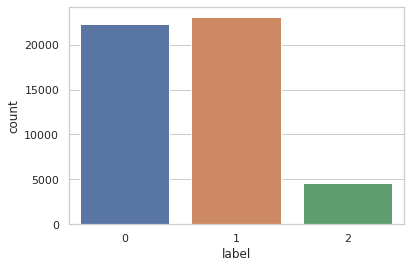

In [40]:
print('Total Counts of label column: \n'.format(),training_data_frame['label'].value_counts())
sns.set(style="whitegrid", color_codes=True)
sns.countplot(x='label', data=training_data_frame)

In [41]:
df_bug = training_data_frame[training_data_frame['label']==0]
df_feature = training_data_frame[training_data_frame['label']==1]
df_question = training_data_frame[training_data_frame['label']==2]

In [42]:
label_counts = training_data_frame.label.value_counts().sort_index()
label_counts

0    22310
1    23044
2     4646
Name: label, dtype: int64

Now we will combine the text in title and body and create new column with name text

In [43]:
def combine(x):
    return x['title'] + " " + x['body']   
training_data_frame['text']= training_data_frame.apply(lambda row : combine(row),axis=1)

In [44]:
print('Number of datapoints with label as Bug :',label_counts[0])
print('Number of datapoints with label as Feature :',label_counts[1])
print('Number of datapoints with label as Question :',label_counts[2])

Number of datapoints with label as Bug : 22310
Number of datapoints with label as Feature : 23044
Number of datapoints with label as Question : 4646


In [45]:
training_data_frame.head()

,title,body,label,text
0,y-zoom piano roll,a y-zoom on the piano roll would be useful.,1,y-zoom piano roll a y-zoom on the piano roll w...
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,0,buggy behavior in selection ! screenshot from ...
2,auto update feature,"hi,\r \r great job so far, @saenzramiro ! : \r...",1,"auto update feature hi,\r \r great job so far,..."
3,filter out noisy endpoints in logs,i think we should stop logging requests to:\r ...,1,filter out noisy endpoints in logs i think we ...
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,0,enable pid on / pid off alarm actions for ardu...


# Preprocessing/Cleaning the data

Let's ensure we make text lowercase, remove text in square brackets, remove links, remove punctuation and remove words containing numbers.

In [24]:
import nltk
import re
import string


def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    return text

**Removing Stopwords & Punctuations**

In [25]:
from string import punctuation
from nltk.corpus import stopwords
nltk.download('stopwords')

def remove_stopwords(git_text):
    # filters charecter-by-charecter : ['h', 'e', 'e', 'l', 'o', 'o', ' ', 'm', 'y', ' ', 'n', 'a', 'm', 'e', ' ', 'i', 's', ' ', 'p', 'u', 'r', 'v', 'a']
    # remove_punctuation = [ch for ch in git_text if ch not in punctuation]
    # convert them back to sentences and split into words
    # remove_punctuation = "".join(remove_punctuation).split()
    filtered_git_text = [word.lower() for word in git_text.split() if word.lower() not in stopwords.words('english')]
    return filtered_git_text

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Visualize the Dataset**

In [26]:
from collections import Counter
import plotly.express as px

def visulize_dataset(data_frame, category):
    
    # Let's apply the above two functions 'clean_text' and 'remove_stopwords' to the whole dataset

    data_frame['text'] = data_frame['text'].apply(lambda x: x.replace("\\r", ""))
    data_frame['text'] = data_frame['text'].apply(lambda x: clean_text(x))
    data_frame["text"] = data_frame["text"].apply(remove_stopwords)
    
    
    word_list = []
    
    for i, j in data_frame.iterrows():
        for word in j['text']:
            word_list.append(word)
        
    count_dict = Counter(word_list)
    most_common_words_df = pd.DataFrame(count_dict.most_common(20), columns=['word', 'count'])
    fig = px.histogram(most_common_words_df,
                       x='word', 
                       y='count',
                       title='Most common terms used while refering to a GitHub {}'.format(category),
                       color_discrete_sequence=['#843B62'] )
    fig.show()

**Printing the text field after Cleaning**

In [46]:
"""
label 0: Bug
label 1: Feature
label 2: Question
"""
training_data_frame['text'] = training_data_frame['text'].apply(lambda x: x.replace("\\r", ""))
training_data_frame['text'] = training_data_frame['text'].apply(lambda x: clean_text(x))
training_data_frame.head()

,title,body,label,text
0,y-zoom piano roll,a y-zoom on the piano roll would be useful.,1,yzoom piano roll a yzoom on the piano roll wou...
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,0,buggy behavior in selection screenshot from ...
2,auto update feature,"hi,\r \r great job so far, @saenzramiro ! : \r...",1,auto update feature hi great job so far saenz...
3,filter out noisy endpoints in logs,i think we should stop logging requests to:\r ...,1,filter out noisy endpoints in logs i think we ...
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,0,enable pid on pid off alarm actions for expe...


Now remove stopwords and punctuation

In [ ]:
training_data_frame['text'] = training_data_frame["text"].apply(remove_stopwords)
training_data_frame.head()

In [47]:
training_data_frame.describe

<bound method NDFrame.describe of                                                    title  \
0                                      y-zoom piano roll   
1                            buggy behavior in selection   
2                                    auto update feature   
3                     filter out noisy endpoints in logs   
4      enable pid on / pid off alarm actions for ardu...   
...                                                  ...   
49995  weapon power meter increase upon shield loss, ...   
49996  kas 1.0: rts-1 doesn't see all the resources o...   
49997                               add a picking system   
49998                               upgrade to ionic 3.0   
49999                         implement tabbed interface   

                                                    body  label  \
0            a y-zoom on the piano roll would be useful.      1   
1      ! screenshot from 2016-02-23 21 27 40  https:/...      0   
2      hi,\r \r great job so far, @saenzrami

Now create a directory name data which will hold the processed data

In [48]:
%mkdir data

mkdir: cannot create directory ‘data’: File exists


We only need the text and label column from our data for training. Extract text and label column from data_frame and write it in data directory

In [51]:
from sklearn.model_selection import train_test_split

train, validation = train_test_split(training_data_frame[['label', 'text']])
train.to_csv("./data/train.csv", index = False)
validation.to_csv("./data/validation.csv", index = False)

Repeat same steps for testing data. Clean and preprocess it and write the data in test.csv file in data directory

In [52]:
# Combining title and body and creating new column with name text
test_df['text'] = test_df.apply(lambda row : combine(row),axis=1)
# Clean the text column by removing punctuation, stopwords etc
test_df['text'] = test_df['text'].apply(lambda x: x.replace("\\r", ""))
test_df['text'] = test_df['text'].apply(lambda x: clean_text(x))
#test_df['text'] = test_df['text'].apply(lambda x: remove_stopwords(x))
test_df.head()
# Extract text and label column
test = test_df[['text']]
test.to_csv("./data/test.csv", index = False)

In [32]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Upload data to S3

Get sagemaker session, s3 bucket to upload data

In [33]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
prefix = 'mlcapstone/bug_prediction'
role = sagemaker.get_execution_role()

Upload the data to S3

In [53]:
input_train = sagemaker_session.upload_data("./data/train.csv", bucket=bucket, key_prefix=prefix)
input_validation = sagemaker_session.upload_data("./data/validation.csv", bucket=bucket, key_prefix=prefix)
input_test = sagemaker_session.upload_data("./data/test.csv", bucket=bucket, key_prefix=prefix)

# Creating Model on Sagemaker

In [54]:
from sagemaker.pytorch import PyTorch

# place to save model artifact
output_path = "s3://{}/{}".format(bucket, prefix)

estimator = PyTorch(
    entry_point="train_deploy.py",
    source_dir="train",
    role=role,
    framework_version="1.3.1",
    py_version="py3",
    train_instance_count=1,
    train_instance_type="ml.p2.xlarge",
    output_path=output_path,
    hyperparameters={
        "epochs": 5,
        "num_labels": 3
    }
)
estimator.fit({"training": input_train, "testing": input_validation})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2021-01-31 17:03:29 Starting - Starting the training job...
2021-01-31 17:03:32 Starting - Launching requested ML instances.........
2021-01-31 17:05:03 Starting - Preparing the instances for training......
2021-01-31 17:06:28 Downloading - Downloading input data......
2021-01-31 17:07:12 Training - Downloading the training image............
2021-01-31 17:09:29 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-01-31 17:09:30,565 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-01-31 17:09:30,596 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-01-31 17:09:33,617 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-01-31 17:09:33,944 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.

UnexpectedStatusException: Error for Training job pytorch-training-2021-01-31-17-03-29-449: Failed. Reason: AlgorithmError: ExecuteUserScriptError:
Command "/opt/conda/bin/python train_deploy.py --epochs 5 --num_labels 3"
Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]Downloading: 100%|ââââââââââ| 232k/232k [00:00<00:00, 33.6MB/s]
Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]Downloading: 100%|ââââââââââ| 433/433 [00:00<00:00, 455kB/s]
Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]Downloading:   1%|          | 5.50M/440M [00:00<00:07, 55.0MB/s]Downloading:   3%|â         | 11.1M/440M [00:00<00:07, 55.3MB/s]Downloading:   4%|â         | 16.9M/440M [00:00<00:07, 56.0MB/s]Downloading:   5%|â         | 22.7M/440M [00:00<00:07, 56.6MB/s]Downloading:   6%|â         | 28.2M/440M [00:00<00:07, 56.0MB/s]Downloading:   8%|â         | 34.1M/440M [00:00<00:07, 57.0MB/s]Downloading:   9%|â         | 40.1M/440M [00:00<00:06, 57.9MB/s]Downloading:  10%|â         | 46.1M/440M [00:00<00:06, 58.4MB/s]Downloading:  12%|ââ        | 52.1M/4

Deploy our endpoint, we call deploy() on our PyTorch estimator object, passing in our desired number of instances and instance type:

In [ ]:
predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

Configure the predictor to use application/json

In [ ]:
predictor.serializer = sagemaker.serializers.JSONSerializer()
predictor.deserializer = sagemaker.deserializers.JSONDeserializer()

Test with sample data

In [ ]:
result = predictor.predict(training_data_frame[0]['text'])
print("predicted class: ", np.argmax(result, axis=1))

In [ ]:
# Use the model for testing

Once deployed, we can read in the test data and send it off to our deployed model to get some results. Once we collect all of the results we can determine how accurate our model is.

In [ ]:
test_X = pd.concat([pd.DataFrame(test_X_len), pd.DataFrame(test_X)], axis=1)

# Creating the Model

First create the BERT model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertModel.from_pretrained("bert-base-uncased")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

model.to(device)
criterion.to(device)

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Bert conversion of sentences

In [ ]:
# some basic operations to understand how BERT converts a sentence into tokens and then into IDs
sample_body = 'script stopped adding videos saenzramiro abc xyz'
tokens = tokenizer.tokenize(sample_body)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_body}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

Adding [CLS]:101, [SEP]:102, [PAD]:0

In [ ]:
# using encode_plus to add special tokens : [CLS]:101, [SEP]:102, [PAD]:0
encodings = tokenizer.encode_plus(
            sample_body,
            max_length=32,
            add_special_tokens=True,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
)

encodings.keys()

In [ ]:
print('Input IDs : {}'.format(encodings['input_ids'][0]))
print('\nAttention Mask : {}'.format(encodings['attention_mask'][0]))

In [ ]:
MAX_LENGTH = 512

Construct a Class for GitHub Messages

In [ ]:
class Git_Message(Dataset):
    def __init__(self, git_messages, label, tokenizer, max_len):
        self.git_messages = git_messages
        self.label = label
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.git_messages)

    def __getitem__(self, item):
        git_messages = str(self.git_messages[item])
        label = self.label[item]
        
        encoding = self.tokenizer.encode_plus(
        git_messages,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt')
        return {
        'git_messages': git_messages,
         'input_ids': encoding['input_ids'],
         'attention_mask': encoding['attention_mask'],
         'label': torch.tensor(label, dtype=torch.long)
          }

# Creating Train, Test Validation

In [ ]:
from sklearn.model_selection import train_test_split

training_data_frame.head()
training_data_frame = training_data_frame[:2000]

In [ ]:
training_data, testing_data = train_test_split(
    training_data_frame,
    test_size=0.1,
    random_state=RANDOM_SEED
)

testing_data, validation_data = train_test_split(
    testing_data,
    test_size=0.5,
    random_state=RANDOM_SEED
)

In [ ]:
training_data.shape, testing_data.shape, validation_data.shape

# Creating Data loader

In [ ]:
def create_data_loader(data, tokenizer, max_len, batch_size):
    
    ds = Git_Message(git_messages=data.text.to_numpy(),
    label=data.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len)
    
    return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4)


BATCH_SIZE = 16
train_data_loader = create_data_loader(training_data, tokenizer, MAX_LENGTH, BATCH_SIZE)
testing_data_loader = create_data_loader(testing_data, tokenizer, MAX_LENGTH, BATCH_SIZE)
val_data_loader = create_data_loader(validation_data, tokenizer, MAX_LENGTH, BATCH_SIZE)

In [ ]:
training_data_frame = next(iter(train_data_loader))
training_data_frame.keys()

In [ ]:
training_data_frame['input_ids'].squeeze().shape, training_data_frame['attention_mask'].squeeze().shape, training_data_frame['label'].shape

In [ ]:
print('git_messages  : ', training_data_frame['git_messages'][0])
print('input_ids : ', training_data_frame['input_ids'].squeeze()[0])
print('attention_mask : ', training_data_frame['attention_mask'].squeeze()[0])
print('label : ', training_data_frame['label'][0])

In [ ]:
bert_model = BertModel.from_pretrained("bert-base-uncased")

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encodings['input_ids'],
  attention_mask=encodings['attention_mask']
)

In [ ]:
last_hidden_state.shape, pooled_output.shape

# Predictor Model

In [ ]:


class BugPredictor(nn.Module):
    
    def __init__(self, n_classes):
        super(BugPredictor, self).__init__()
        self.bert_model = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(p=0.0)
        self.out = nn.Linear(self.bert_model.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert_model(
        input_ids=input_ids,
        attention_mask = attention_mask
        )
        output = self.dropout(pooled_output)
        return self.out(output)

Let's Start Training the Model

In [ ]:
"""
label 0: Bug
label 1: Feature
label 2: Question
"""
class_names = [0, 1, 2]
bug_predictor_model = BugPredictor(len(class_names))
bug_predictor_model = bug_predictor_model.to(device)

In [ ]:
EPOCHS = 10

optimizer = AdamW(bug_predictor_model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d['input_ids'].squeeze().to(device)
        attention_mask = d['attention_mask'].squeeze().to(device)
        targets = d['label'].to(device)

        outputs = model(input_ids = input_ids, attention_mask = attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        
        correct_predictions += torch.sum(preds==targets)
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double()/n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].squeeze().to(device)
            attention_mask = d['attention_mask'].squeeze().to(device)
            targets = d['label'].to(device)

            outputs = model(input_ids = input_ids, attention_mask = attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds==targets)
            losses.append(loss.item())
    
    return correct_predictions.double()/n_examples, np.mean(losses)

In [ ]:
%%time
from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print('EPOCH {}/{}'.format(epoch+1,EPOCHS))
    print('-' * 10)
  
    train_acc, train_loss = train_model(bug_predictor_model, train_data_loader, loss_fn, optimizer, device, scheduler, len(training_data))
    
    print('Train loss : {} accuracy : {}'.format(train_loss, train_acc))
    
    val_acc, val_loss = eval_model(bug_predictor_model, val_data_loader, loss_fn, device, len(validation_data))
    
    print('Validation loss : {} accuracy : {}'.format(val_loss, val_acc))
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
        print('Saving the best model ...')
        torch.save(bug_predictor_model.state_dict(), 'best_model.bin')
        best_accuracy = val_acc

# Results

In [ ]:
sample_bug_message = "Script stopped adding video's. A recent change in the youtube layout broke the script. Probably caused by element names being altered."

In [ ]:
class_names = ['bug', 'feature', 'question']

In [ ]:
def predict_git_category(sample_message, model):
    encoded_message = tokenizer.encode_plus(sample_bug_message, max_length=MAX_LENGTH, add_special_tokens=True, return_token_type_ids=False, pad_to_max_length=True, return_attention_mask=True, return_tensors='pt')
    input_ids = encoded_message['input_ids'].to(device)
    attention_mask = encoded_message['attention_mask'].to(device)
    
    output = model(input_ids=input_ids, attention_mask=attention_mask)
    _, prediction_idx = torch.max(output, dim=1)
        
    return class_names[prediction_idx]

In [ ]:
print('Sample bug message : ', sample_bug_message)
print('Predicted GitHub Category : ', predict_git_category(sample_bug_message, bug_predictor_model))